# Hybrid Models
Combine the strengths of two forecasters with this powerful technique.


# 🚀 Hybrid Forecasting with Residuals

## 🌟 Introduction

Linear regression 📈 is great at **extrapolating trends**, but not at learning interactions.  
XGBoost 🌲 excels at **learning interactions**, but it **can't extrapolate trends**.  

In this lesson, we'll learn how to create **hybrid forecasters** 🤝 that **combine complementary learning algorithms** and let the strengths of one make up for the weakness of the other.

---

## 🔍 Components and Residuals

To build smart hybrids, we need to understand how time series are made.  
They typically consist of:

🧱 `series = trend + seasons + cycles + error`

These are called the **components** of the time series.

🧮 **Residuals** = Target - Prediction  
Residuals represent what the model failed to learn. They’re what’s left over after fitting the model.

📉 Example: Fit a trend-seasonal model → Subtract it → What remains is the residual.  
Residuals contain everything the model missed!

We can think of learning a time series like peeling an onion 🧅:

1. Learn the **trend** and subtract it 🪜  
2. Learn the **seasonality** from residuals and subtract it 📆  
3. Learn the **cycles** and subtract them 🔄  
4. What’s left? Just the **random noise** 🌫️

➡️ Add all the components back together to get the full picture!

---

## 🤖 Hybrid Forecasting with Residuals

Previously, we used a **single model** to learn everything at once. But we can be smarter:

🎯 Use:
- One algorithm for some components (e.g., trend)
- Another for the rest (e.g., interactions)

### 🧠 The 3-Step Hybrid Strategy:

```python
# 1. Train and predict with first model (e.g., linear regression)
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)

# 2. Train and predict with second model on residuals (e.g., XGBoost)
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)

# 3. Add predictions to get final result
y_pred = y_pred_1 + y_pred_2
```

📌 Tip: Use **different feature sets** for each model.  
If model 1 handles the trend, model 2 doesn’t need trend features.

🧩 Most popular combo:
- A **simple** model (like linear regression)
- Followed by a **complex** model (like XGBoost or a neural net)

---

## 🛠️ Designing Hybrids

Let's peek inside the models 🕵️:

### 1. 🔄 Feature-Transforming Algorithms:
- Transform input features into predictions.
- Can **extrapolate** beyond training data!
- Examples: **Linear regression**, **Neural networks**

### 2. 📦 Target-Transforming Algorithms:
- Group target values by feature rules.
- **Cannot extrapolate** beyond training data.
- Examples: **Decision trees**, **KNN**

⛔ Trees can’t forecast future trends.  
✅ But linear models can draw a trendline beyond the last data point.

---

## 💡 Why Hybrid?

Use a **linear model** to handle the trend ➡️ Subtract the trend ➡️  
Use **XGBoost** to learn complex patterns in the residuals. 🎯

🧠 Want to hybridize a **neural net**?  
Use the predictions from another model as a feature (a technique called **stacking**).

---

## 🧬 Terminology Recap

- 🔁 **Boosted Hybrid**: Fits the residuals (like gradient boosting)
- 🧱 **Stacked Hybrid**: Uses one model’s predictions as input features to another

---


In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor


comp_dir = Path(r'C:\Users\samad\OneDrive\Bureau\ml\times_series\store_sales_dataset')
data_dir = Path(r"C:\Users\samad\OneDrive\Bureau\ml\times_series\Datasets_1")

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

C:\Users\samad\AppData\Local\Temp\ipykernel_32312\1271576000.py:14: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(
C:\Users\samad\AppData\Local\Temp\ipykernel_32312\1271576000.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['family', 'date'])


Create a boosted hybrid for the Store Sales dataset by implementing a new Python class. 

In [2]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

# 1) Define fit method for boosted hybrid

In [3]:
def fit(self, X_1, X_2, y):
    # Train model_1
    self.model_1.fit(X_1, y)

    # Make predictions
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=y.columns,
    )

    # Compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # Train model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

-------------------------------------------------------------------------------

# 2) Define predict method for boosted hybrid

In [ ]:
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        # YOUR CODE HERE: predict with self.model_1
        self.model_1.predict(X_1),
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    #add self.model_2 predictions to y_pred
    y_pred += self.model_2.predict(X_2)
    
    return y_pred.unstack()  # long to wide


# Add method to class
BoostedHybrid.predict = predict


Ready to use the new BoostedHybrid class to create a model for the Store Sales data!!

In [5]:
# Target series
y = family_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

C:\Users\samad\AppData\Local\Temp\ipykernel_32312\3489191612.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature


# 3) Train boosted hybrid

Create the hybrid model by initializing a `BoostedHybrid` class with `LinearRegression()` and `XGBRegressor()` instances.

In [6]:
# Create model
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)
model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)

We might want to use other hybrid combinations than the linear regression + XGBoost hybrid we've created in the previous questions

In [9]:
# Model 1 (trend)
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid

# different combinations of the algorithms above
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)

First date in index: 2017-01-01
Last date in index: 2017-08-15
X1_valid shape: (45, 1)
X2_valid shape: (1517, 3)


C:\Users\samad\AppData\Local\Temp\ipykernel_32312\3639629927.py:38: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
C:\Users\samad\AppData\Local\Temp\ipykernel_32312\3639629927.py:39: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)


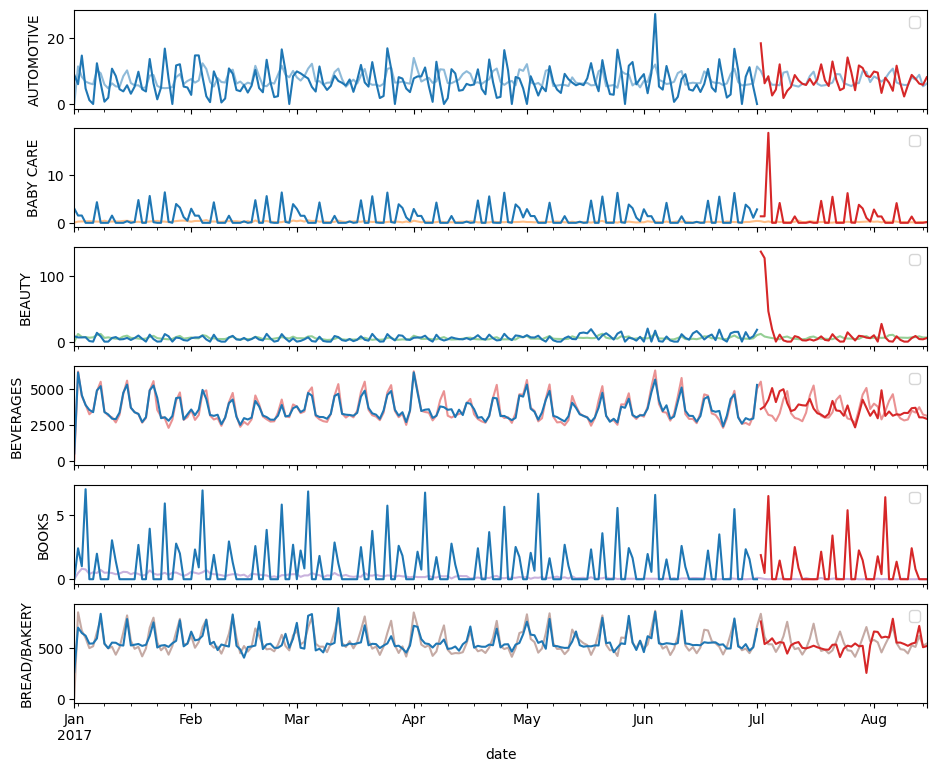

In [10]:
plot_params = {'figsize': (10, 6)}

# Check actual dates in your index
print(f"First date in index: {y.index[0]}")
print(f"Last date in index: {y.index[-1]}")

# Use date slicing consistently with loc for cleaner indexing
split_date = "2017-07-01"  # adjust if needed based on above output

y_train = y.loc[:split_date]
y_valid = y.loc[split_date:].iloc[1:]  # Skip the split date itself for validation

X1_train = X_1.loc[:split_date]
X1_valid = X_1.loc[split_date:].iloc[1:]

X2_train = X_2.loc[:split_date]
X2_valid = X_2.loc[split_date:].iloc[1:]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
print(f"X1_valid shape: {X1_valid.shape}")
print(f"X2_valid shape: {X2_valid.shape}")

# Align the indices before prediction
X2_valid = X2_valid.loc[X1_valid.index]

# Now try predicting again
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)



families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

# 4) Fit with different learning algorithms


First date in index: 2017-01-01
Last date in index: 2017-08-15
X1_valid shape: (45, 1)
X2_valid shape: (1517, 3)


C:\Users\samad\AppData\Local\Temp\ipykernel_32312\4234849071.py:42: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
C:\Users\samad\AppData\Local\Temp\ipykernel_32312\4234849071.py:43: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)


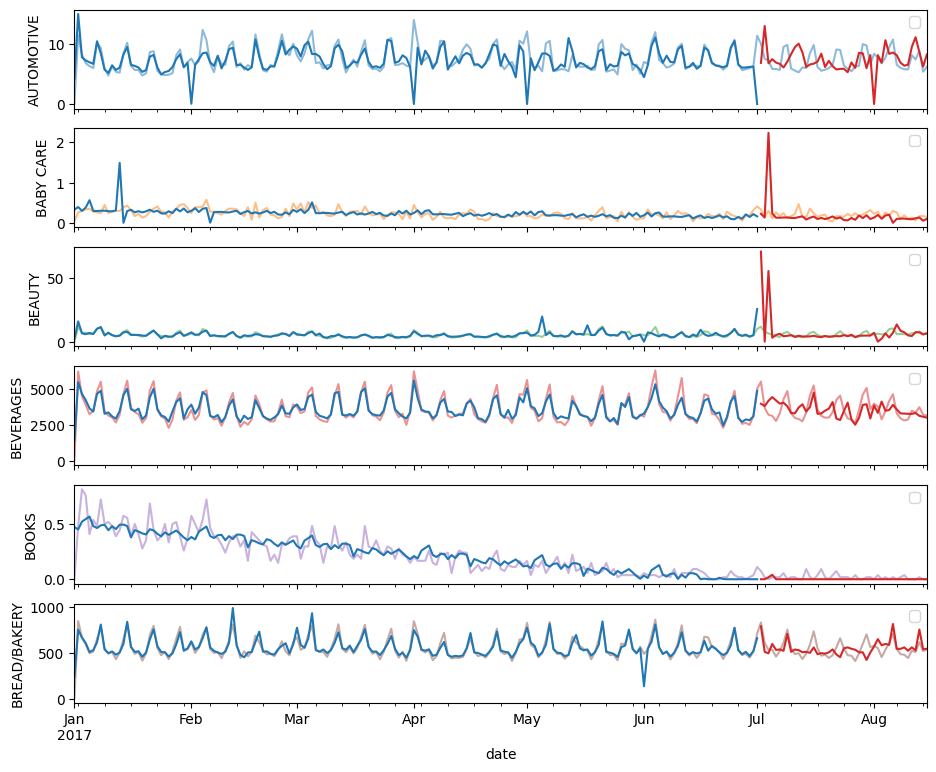

In [13]:
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=RandomForestRegressor(),
)
plot_params = {'figsize': (10, 6)}

# Check actual dates in your index
print(f"First date in index: {y.index[0]}")
print(f"Last date in index: {y.index[-1]}")

# Use date slicing consistently with loc for cleaner indexing
split_date = "2017-07-01"  # adjust if needed based on above output

y_train = y.loc[:split_date]
y_valid = y.loc[split_date:].iloc[1:]  # Skip the split date itself for validation

X1_train = X_1.loc[:split_date]
X1_valid = X_1.loc[split_date:].iloc[1:]

X2_train = X_2.loc[:split_date]
X2_valid = X_2.loc[split_date:].iloc[1:]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
print(f"X1_valid shape: {X1_valid.shape}")
print(f"X2_valid shape: {X2_valid.shape}")

# Align the indices before prediction
X2_valid = X2_valid.loc[X1_valid.index]

# Now try predicting again
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)



families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)